# Using the VQE Module for Quantum Chemistry Calculations

In this tutorial, you will learn how to use QXMT's Variational Quantum Eigensolver (VQE) module for quantum chemistry calculations. VQE is a hybrid quantum-classical algorithm designed to find the ground state energy of molecules, which is a fundamental problem in quantum chemistry.

## 1. Understanding VQE Configuration

QXMT's VQE module requires specific configuration elements that differ from the quantum kernel models. Here's an overview of the key components:

- **global_settings**: Defines global configuration parameters including:
  - `random_seed`: Sets a seed for reproducibility
  - `model_type`: Must be set to "vqe" to use the VQE module

- **hamiltonian**: Specifies the molecular Hamiltonian to be solved:
  - `module_name`: Module containing the Hamiltonian implementation
  - `implement_name`: Class name of the Hamiltonian implementation
  - `params`: Parameters for the Hamiltonian, such as molecule specification

- **device**: Configures the quantum device for running simulations:
  - `platform`: Currently supports "pennylane"
  - `device_name`: Device to use (e.g., "lightning.qubit")
  - `n_qubits`: Number of qubits required for the simulation
  - `shots`: Number of measurement shots (null for exact simulation)

- **ansatz**: Specifies the variational ansatz to use:
  - `module_name`: Module containing the ansatz implementation
  - `implement_name`: Class name of the ansatz implementation
  - `params`: Parameters for the ansatz

- **model**: Specifies the VQE model implementation and optimization settings:
  - `name`: Model implementation (currently "basic")
  - `diff_method`: Differentiation method for optimization (e.g., "adjoint")
  - `optimizer_settings`: Configuration for the classical optimizer
  - `params`: Additional parameters like maximum iterations

- **evaluation**: Lists the evaluation metrics to be used:
  - `default_metrics`: Metrics like "final_cost" and "hf_energy"
  - `custom_metrics`: Any custom metrics to be calculated

## 2. Example Configuration for H₂ Molecule

Here's an example configuration for calculating the ground state energy of an H2 molecule:

```yaml
description: "VQE calculation for H2 molecule"

global_settings:
  random_seed: 42
  model_type: "vqe"

hamiltonian:
  module_name: "qxmt.hamiltonians.pennylane"
  implement_name: "MolecularHamiltonian"
  params:
    molname: "H2"
    basis_name: "STO-3G"
    bondlength: 0.74
    active_electrons: 2
    active_orbitals: 2

device:
  platform: "pennylane"
  device_name: "lightning.qubit"
  n_qubits: 4
  shots: null
  random_seed: 42

ansatz:
  module_name: "qxmt.ansatze.pennylane"
  implement_name: "UCCSDAnsatz"
  params: null

model:
  name: "basic"
  diff_method: "adjoint"
  optimizer_settings:
    name: "Adam"
    params:
      stepsize: 0.01
      beta1: 0.9
      beta2: 0.999
  params:
    max_steps: 20
    verbose: false

evaluation:
  default_metrics:
  - "final_cost"
  - "hf_energy"
  - "fci_energy"
  custom_metrics: []
```

You can also specify the molecule structure explicitly:

```yaml
hamiltonian:
  module_name: "qxmt.hamiltonians.pennylane"
  implement_name: "MolecularHamiltonian"
  params:
    symbols: ["H", "H"]
    coordinates: [[0.0, 0.0, 0.0], [0.0, 0.0, 0.74]]
    charge: 0
    multi: 1
    basis_name: "STO-3G"
    active_electrons: 2
    active_orbitals: 2
    unit: "angstrom"
```

NOTE: Currently, the explicit mode does not support FCI energy evaluation.

## 3. Running a VQE Calculation

To run a VQE calculation, you can use the same experiment framework as with quantum kernel models:

In [19]:
import qxmt
from qxmt.experiment.schema import VQEEvaluations
from typing import cast

# Initialize experiment
experiment = qxmt.Experiment(
    name="vqe_h2_experiment",
    desc="VQE calculation for H2 molecule",
    auto_gen_mode=False,
).init()

# Run the experiment with the VQE configuration
config_path = "../configs/vqe_h2.yaml"
artifact, result = experiment.run(config_source=config_path)

# Access the results
final_energy = cast(VQEEvaluations, result.evaluations).optimized["final_cost"]
hf_energy = cast(VQEEvaluations, result.evaluations).optimized["hf_energy"]
fci_energy = cast(VQEEvaluations, result.evaluations).optimized["fci_energy"]
print(f"VQE Energy: {final_energy}")
print(f"HF Energy: {hf_energy}")
print(f"FCI Energy: {fci_energy}")

Optimizing ansatz with 3 parameters through 20 steps
Optimization finished. Final cost: -1.13622722


VQE Energy: -1.1362272195288956
HF Energy: -1.11675922817382
FCI Energy: -1.1372838216460408


In [20]:
experiment.runs_to_dataframe()

,run_id,final_cost,hf_energy,fci_energy
0,1,-1.136227,-1.116759,-1.137284


## 4. Visualizing Optimization Progress

QXMT provides functionality to visualize the optimization progress during VQE calculations. You can plot the energy convergence as follows:

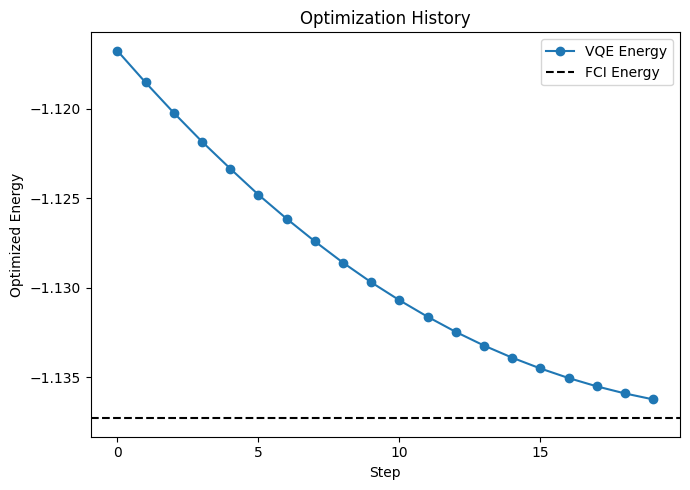

In [22]:
from qxmt.visualization import plot_optimization_history
from qxmt.models.vqe import BaseVQE

# Plot the optimization history
plot_optimization_history(
    cost_history=cast(BaseVQE, artifact.model).cost_history,
    cost_label="VQE Energy",
    baseline_cost=fci_energy,
    baseline_label="FCI Energy",
    y_label="Optimized Energy",
    save_path=experiment.experiment_dirc / f"run_{experiment.current_run_id}/optimization.png"
)

---

### Version Information
| Environment | Version |
|----------|----------|
| document | 2025/05/12 |
| QXMT| v0.5.1 |